# Dataset: Carbon dioxide

## The Keeling Curve

The [Keeling Curve](https://en.wikipedia.org/wiki/Keeling_Curve) is a graph of the accumulation of carbon dioxide in the Earth's atmosphere based on continuous measurements taken at the Mauna Loa Observatory on the island of Hawaii. The curve is named for the scientist Charles David Keeling, who started the monitoring program and supervised it until his death in 2005. Keeling published the first "Keeling Curve" of monthly carbon dioxide records from Mauna Loa from 1958 to 1960 in the journal Tellus in 1960, and reported that the year-to-year increase in carbon dioxide roughly matched the amount of fossil fuels burned per year. By 1976, it was well established that the rising carbon dioxide in the curve was due to anthropogenic emissions. 

The carbon dioxide data from Mauna Loa are freely available to [download](http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record) from the Scripps Institution of Oceanography, so we are going to go ahead and recreate the curve.

In [1]:
!head -n 60 monthly_in_situ_co2_mlo.csv

"-------------------------------------------------------------------------------------------"
" Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                "
" at Mauna Loa, Observatory, Hawaii: Latitude 19.5°N Longitude 155.6°W Elevation 3397m      "
"                                                                                           "
" Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   "
" Scripps CO2 Program ( http://scrippsco2.ucsd.edu )                                        "
" Scripps Institution of Oceanography (SIO)                                                 "
" University of California                                                                  "
" La Jolla, California USA 92093-0244                                                       "
"                                                                                           "
" Status of data and correspondence:                        

### Read and clean data

*It may be preferable to edit the input file so that this complicated clean-up isn't the first thing that novice learners need to do.*

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def read_scripps_data(infile):
    """Read and clean CO2 data from Scripps"""
    
    df = pd.read_csv(infile, skiprows=54)

    # Select year, month and CO2 columns
    df = df.iloc[2:, [0,1,4]]
    df = df.reset_index(drop=True)

    # Remove whitespace from column names
    df = df.rename(columns=lambda x: x.strip())
    
    # Replace the default index column with datetime objects
    df.rename(columns={'Yr': 'year', 'Mn': 'month'}, inplace=True)
    df['day'] = 15
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df = df.drop(columns=['year', 'month', 'day'])
    df = df.set_index(['date'])

    # Replace missing values (-99.99) with NaNs
    df = df.astype(float).replace(-99.99, np.nan)
    
    return df

In [4]:
mlo_df = read_scripps_data('monthly_in_situ_co2_mlo.csv')

In [5]:
%matplotlib inline

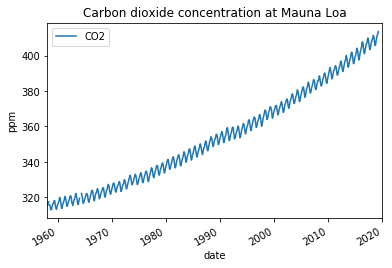

In [6]:
mlo_df.plot()
plt.ylabel('ppm')
plt.title('Carbon dioxide concentration at Mauna Loa')
plt.savefig('keeling.png')

## Premier Global Baseline Stations

Mauna Loa isn't the only place where carbon dioxide is measured. The [Global Atmosphere Watch](http://www.wmo.int/pages/prog/arep/gaw/gaw_home_en.html) programme of the World Meteorological Organization has global baseline stations distributed around the globe. The three premier global baseline stations are:

* [Mauna Loa, Hawaii, USA](http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record)
* [Cape Grim, Tasmania, Australia](https://www.csiro.au/en/Research/OandA/Areas/Assessing-our-climate/Latest-greenhouse-gas-data)
* [Alert, Nunavut, Canada](http://scrippsco2.ucsd.edu/data/atmospheric_co2/alt)

All three are in remote locations to avoid contamination of air samples from nearby emission sources (e.g. factories).

Similar to Mauna Loa, the Alert data is made available by the Scripps Institution for Oceanography.

In [7]:
alt_df = read_scripps_data('monthly_flask_co2_alt.csv')

The Cape Grim data is provided by CSIRO in Australia and therefore uses a different file format.

In [8]:
!head -n 30 CapeGrim_CO2_data_download.csv

In [9]:
def read_csiro_data(infile):
    """Read and clean CO2 data from CSIRO"""
    
    df = pd.read_csv(infile, skiprows=24)
    
    # Select and rename relevant columns
    df = df.iloc[:, [0,1,2,4]]
    df.rename(columns={'YYYY': 'year', 'MM': 'month', 'DD': 'day', 'CO2(ppm)': 'CO2'}, inplace=True)
    
    # Replace the default index column with datetime objects
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df = df.drop(columns=['year', 'month', 'day'])
    df = df.set_index(['date'])
    
    return df

In [10]:
cgm_df = read_csiro_data('CapeGrim_CO2_data_download.csv')

We can concatenate all three sites into the same pandas data frame and plot them all.

In [11]:
premier_df = pd.concat([mlo_df, alt_df, cgm_df], axis=1)
premier_df.columns = ["Mauna Loa", "Alert", "Cape Grim"]

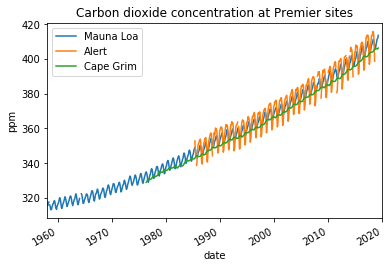

In [12]:
premier_df.plot()
plt.ylabel('ppm')
plt.title('Carbon dioxide concentration at Premier sites')
plt.savefig('baseline_stations.png')

The reason for the close correspondence between the three sites is that once carbon dioxide is emitted into the atmosphere, it tends to hang around for [a long time](https://www.theguardian.com/environment/2012/jan/16/greenhouse-gases-remain-air). Most of it eventaully dissolves into the ocean, but that typically takes 20–200 years. This means there is plenty of time for the atmosphere to mix it more or less evenly around the global atmosphere.

## Seasonal cycle

The major difference between the data from Mauna Loa, Alert and Cape Grim is the seasonal cycle (i.e. the saw-tooth pattern embedded within the increasing trend). Carbon dioxide levels in the atmosphere rise and fall each year as plants, through photosynthesis and respiration, take up the gas in spring and summer, and release it in autumn and winter.

We can plot the seasonal cycle to investigate the differences between the geographic locations corresponding to the premier baseline stations.

In [13]:
df_2000s = premier_df.loc['2000-01-01':'2009-12-31']
seasonal_df = df_2000s.groupby(df_2000s.index.month).mean()

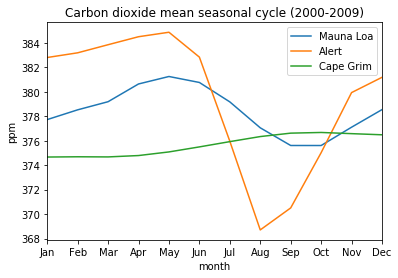

In [14]:
import calendar

seasonal_df.plot()
plt.xlabel('month')
plt.ylabel('ppm')
plt.xticks(np.arange(1, 13), calendar.month_abbr[1:])
plt.title('Carbon dioxide mean seasonal cycle (2000-2009)')
plt.savefig('seasonal_cycle.png')

There's more vegetation in the Northern Hemisphere, so in general the seasonal cycle is largest in that hemisphere. This is clear from our plot: 

* The largest seasonal cycle is at Alert, Canada, which at latitude 82 N is deep within the Northern Hemisphere
* The seasonal cycle is more subdued over the tropical Pacific Ocean (i.e. at Manua Loa) but follows a similar pattern to Alert with a peak in late winter and trough in late summer
* The seasonal cycle in the Southern Hemisphere mid-latitudes (i.e. at Cape Grim) is much smaller (less vegetation) and has an opposite phase (due to the reversal of the seasons relative to the Northern Hemisphere)


## Extension activities

Possible extension activities with the carbon dioxide data include calculating the:

1. *Annual growth rate*: Show that the rate at which carbon dioxide is increasing is rising over time.
```
annual_df = mlo_df.groupby(mlo_df.index.year).mean()
annual_df.diff().plot()
```

2. *Trend in range of seasonal cycle*: The range of the seasonal cycle is expanding as more carbon dioxide is emitted. Specifically, the effect is more pronounced in the Northern Hemisphere, where more carbon is accumulating in forests and other vegetation and soils during the summer, and more carbon is being released in the fall and winter.

We could also explore other atmospheric gases measured by Scripps. In particular, oxygen and carbon isotope data can be used to prove that the extra carbon dioxide in the atmosphere is due to humans burning fossil fuels:

1. *Oxygen*: The [Scripps oxygen data](http://scrippso2.ucsd.edu/) shows a decreasing trend over time, consistent with the increased combustion of fossil fuels around the world.

2. *Carbon isotope ratio*: The [Scripps 13C/12C data](https://cdiac.ess-dive.lbl.gov/trends/co2/iso-sio/iso-sio.html) also shows a decreasing trend over time (i.e. the carbon in the atmosphere is getting "lighter" over time). Plants preferentially take up lighter carbon isotopes, so when you burn fossil fuels (i.e. old dead plant matter) you release those lighter isotopes back into the atmosphere. 